In [108]:
import numpy as np
from tqdm import tqdm
from quantbullet.research.jump_model import (ContinuousJumpModel, 
                                            TestingUtils, 
                                            FeatureGenerator,
                                            SimulationGenerator)
from quantbullet import set_figsize
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Real Data

In [82]:
import yfinance as yf

# Define the ticker symbol
ticker_symbol = "TSLA"

# Fetch data
data = yf.download(ticker_symbol, interval="1d", period="500d")

[*********************100%%**********************]  1 of 1 completed


In [88]:
log_ret = np.log(data['Adj Close'] / data['Adj Close'].shift(1)).dropna().values
enriched_returns = FeatureGenerator().enrich_features(log_ret)
enriched_returns = FeatureGenerator().standarize_features(enriched_returns)
ctsJump = ContinuousJumpModel()

In [89]:
tol = 100
max_iter = 100
K = 2
best_trial_loss = list()
best_trial_states = list()

for _ in range(10):
    centroids = ctsJump.initialize_kmeans_plusplus(enriched_returns, K)
    cur_s = ctsJump.classify_data_to_states(enriched_returns, centroids)
    second_col = 1 - cur_s
    cur_s = np.column_stack((cur_s, second_col))
    cur_loss = float('inf')
    best_states = cur_s
    best_loss = cur_loss
    no_improvement_counter = 0  # Counter for consecutive iterations without improvement
    for _ in tqdm(range(max_iter)):
        cur_theta = ctsJump.fixed_states_optimize(enriched_returns, cur_s, K)  # Assuming 2 states
        lossMatrix = ctsJump.generate_loss_matrix(enriched_returns, cur_theta)
        C = ctsJump.generate_C(K)
        cur_s, cur_loss = ctsJump.fixed_theta_optimize(lossMatrix, lambda_=100, C=C)
        
        # Check if the current solution is better than the best known solution
        if cur_loss < best_loss:
            best_loss = cur_loss
            best_states = cur_s
            no_improvement_counter = 0  # Reset the counter if there's improvement
        else:
            no_improvement_counter += 1  # Increment the counter if no improvement

        # Check for convergence
        if no_improvement_counter >= 3:
            best_trial_loss.append(best_loss)
            best_trial_states.append(best_states)
            break

final_best_loss = min(best_trial_loss)
final_best_states = best_trial_states[best_trial_loss.index(final_best_loss)]
    

 14%|█▍        | 14/100 [00:30<03:05,  2.15s/it]


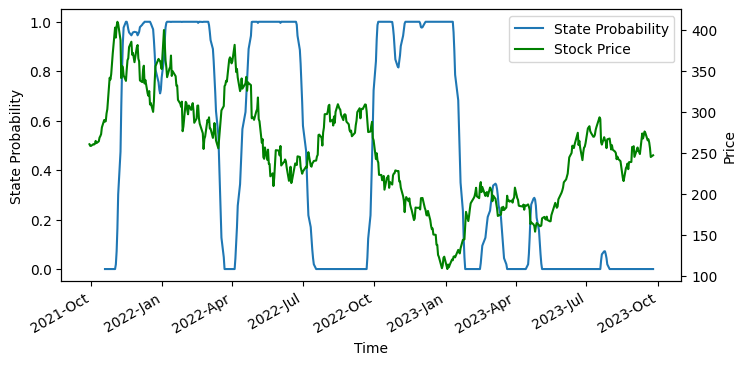

In [118]:
with set_figsize(8, 4):
    fig, ax = plt.subplots()
    ax.plot(data.index[14:], final_best_states[:, 1], label='State Probability')
    ax.set_xlabel('Time')
    ax.set_ylabel('State Probability')

    ax2 = ax.twinx()
    ax2.plot(data.index, data['Adj Close'].values, color='green', label='Stock Price')
    ax2.set_ylabel('Price')

    # Use AutoDateLocator and DateFormatter for x-axis labels
    locator = mdates.AutoDateLocator()
    formatter = mdates.DateFormatter("%Y-%b")
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    fig.autofmt_xdate()  # Rotate and align the tick labels

    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles + handles2, labels + labels2, loc='upper right')

## Continuous Jump Model Dev

In [7]:
np.random.seed(999)

K = 2

# simulate returns and enrich with features
model = ContinuousJumpModel()
transition_matrix, norm_params = TestingUtils().daily()
sim_states, sim_returns = SimulationGenerator().run(
    steps=1000, transition_matrix=transition_matrix, norm_params=norm_params
)
enriched_returns = FeatureGenerator().enrich_features(sim_returns)
enriched_returns = FeatureGenerator().standarize_features(enriched_returns)

# initialize centroids using k-means++
ctsJump = ContinuousJumpModel()
centroids = ctsJump.initialize_kmeans_plusplus(enriched_returns, K)
cur_s = ctsJump.classify_data_to_states(enriched_returns, centroids)
second_col = 1 - cur_s
cur_s = np.column_stack((cur_s, second_col))

09-21 04:36:41 INFO Step 1: Initial (stationary) distribution: [0.84997341 0.15002659]
09-21 04:36:41 INFO Step 2: Simulated states: Counter({0: 633, 1: 368})
09-21 04:36:41 INFO Step 3: Generate simulated return data conditional on states.


In [8]:
tol = 100
max_iter = 100
cur_loss = float('inf')
best_states = cur_s
best_loss = cur_loss
no_improvement_counter = 0  # Counter for consecutive iterations without improvement

for _ in tqdm(range(max_iter)):
    cur_theta = ctsJump.fixed_states_optimize(enriched_returns, cur_s, 2)  # Assuming 2 states
    lossMatrix = ctsJump.generate_loss_matrix(enriched_returns, cur_theta)
    C = ctsJump.generate_C(2)
    cur_s, cur_loss = ctsJump.fixed_theta_optimize(lossMatrix, lambda_=100, C=C)
    
    # Check if the current solution is better than the best known solution
    if cur_loss < best_loss:
        best_loss = cur_loss
        best_states = cur_s
        no_improvement_counter = 0  # Reset the counter if there's improvement
    else:
        no_improvement_counter += 1  # Increment the counter if no improvement

    # Check for convergence
    if no_improvement_counter >= 3:
        break
    
print(best_loss)

  8%|▊         | 8/100 [00:26<04:59,  3.25s/it]

5828.433954756139
